# Loading Necessary Libraries

In [1]:
import pyodbc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import warnings

warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

C:\Users\motiur\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\motiur\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Loading Data

In [2]:
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=...;DATABASE=...;UID=...;PWD=...')
cursor = cnxn.cursor()

In [3]:
sql ="""SELECT s.Order_ID, s.Channel_Name, s.Order_date, s.Customer_ID,s.Customer_Code, s.Customer_Name,
        s.Item_ID, s.Base_UoM, s.Item_Code, s.Order_Qty, s.Order_Value, s.Item_Price,
        s.Delivered_Value, s.Delivered_Qty, s.Pending_Qty, s.Pending_Value, s.Shippoint_ID, s.Shippoint_Name, 
        s.Plant_Name, c.Region_Id, c.Region, c.Area_Id, c.Area, c.Territory_Id, c.Territory, c.Exclusivity_Type, 
        c.Credit_Facility_Type
 
 FROM [SSISRND].[o2c].[SalesOrderInformation] as s
  join SSISRND.o2c.CustomerDatabase as c on c.Customer_ID = s.Customer_ID
  where s.[Unit_ID] = 4 and s.[Channel_Name]='Enterprise'"""

soi = pd.read_sql(sql,cnxn)

In [4]:
soi.head(2)

,Order_ID,Channel_Name,Order_date,Customer_ID,Customer_Code,Customer_Name,Item_ID,Base_UoM,Item_Code,Order_Qty,...,Shippoint_Name,Plant_Name,Region_Id,Region,Area_Id,Area,Territory_Id,Territory,Exclusivity_Type,Credit_Facility_Type
0,648294,Enterprise,2023-10-28 00:00:00.0000000,15066,1359063,M.S.S BD Corporation Gazaria Exclusive,102630,Bag,14411384,300.0,...,ACCL Factory,ACCL Narayanganj,None,Dhaka,613,Dhaka South,None,Gazaria,Exclusive,Credit
1,648395,Enterprise,2023-10-28 00:00:00.0000000,66776,22214834,M/S Jayan Traders - Gafargaon Exclusive,102630,Bag,14411384,400.0,...,ACCL Factory,ACCL Narayanganj,None,Mymensingh,615,Mymensingh,None,Gafargaon,Exclusive,Credit


In [5]:
soi['Order_date']=pd.to_datetime(soi['Order_date'])

In [6]:
df = soi.groupby(['Customer_ID','Order_date']).agg({
    'Order_Qty': 'sum',
    'Item_Price': 'mean',
    'Delivered_Qty': 'sum'
}).reset_index()

In [7]:
df.head()

,Customer_ID,Order_date,Order_Qty,Item_Price,Delivered_Qty
0,14252,2021-09-01,0.0,461.0,0.0
1,14252,2021-09-05,1400.0,461.0,700.0
2,14252,2021-09-08,0.0,461.0,0.0
3,14252,2021-09-09,5500.0,461.0,2750.0
4,14252,2021-09-15,700.0,461.0,350.0


# Removing Zero Order Quantity Input price less than 300

In [8]:
df.shape

(122639, 5)

In [9]:
df = df[df['Order_Qty']>0]

In [10]:
df = df[df['Item_Price']>300]

# Order Year, Month, Day Incorporation

In [11]:
df['Year'] = df['Order_date'].dt.year
df['Month'] = df['Order_date'].dt.month
df['Day'] = df['Order_date'].dt.day

# Daily Order Count

In [12]:
Order_count = df.groupby(['Year','Month','Day']).agg({
    'Customer_ID':'count',
    'Order_Qty': 'sum'
}).reset_index()
Order_count.rename(columns = {'Customer_ID':'Order_freq','Order_Qty':'Total Order'}, inplace = True) 
Order_count.tail(10)

,Year,Month,Day,Order_freq,Total Order
901,2024,2,23,126,102531.0
902,2024,2,24,154,123575.0
903,2024,2,25,190,189941.0
904,2024,2,26,163,122460.0
905,2024,2,27,195,189960.0
906,2024,2,28,173,176806.0
907,2024,2,29,191,220658.0
908,2024,3,1,75,50160.0
909,2024,3,2,56,32635.0
910,2024,3,3,1,500.0


In [13]:
Order_count['Date'] = pd.to_datetime(Order_count[['Year', 'Month', 'Day']])
Order_count = Order_count.sort_values('Date')

In [14]:
Order_count.head()

,Year,Month,Day,Order_freq,Total Order,Date
0,2021,9,1,30,37430.0,2021-09-01
1,2021,9,2,43,65614.0,2021-09-02
2,2021,9,3,20,21710.0,2021-09-03
3,2021,9,4,35,53530.0,2021-09-04
4,2021,9,5,54,86830.0,2021-09-05


In [15]:
dail_Order_freq = Order_count[['Order_freq','Date']]
dail_Order_InBag = Order_count[['Total Order','Date']]
dail_Order_freq.set_index('Date', inplace=True)
dail_Order_InBag.set_index('Date', inplace=True)

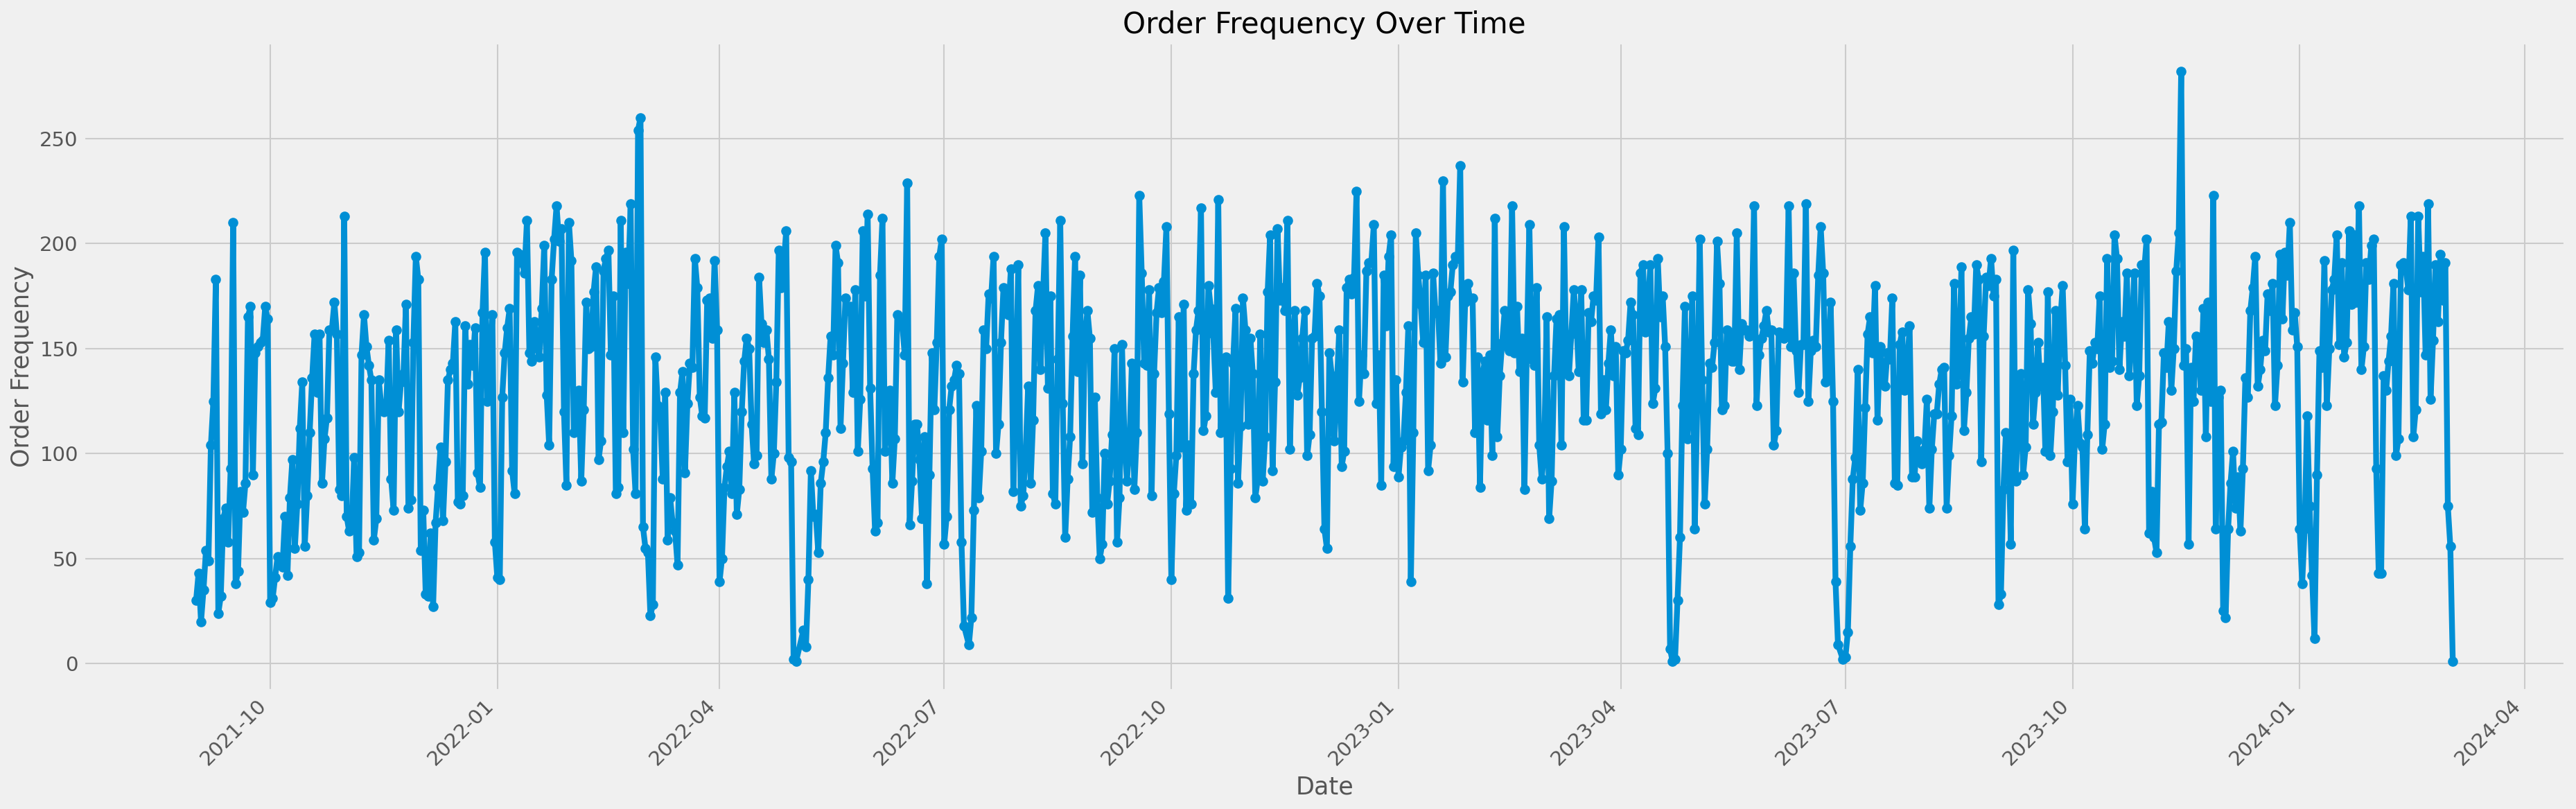

In [16]:
plt.figure(figsize=(25, 8), dpi=150)
dail_Order_freq['Order_freq'].plot(marker='o', linestyle='-')
plt.title('Order Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Order Frequency')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df.head()

,Customer_ID,Order_date,Order_Qty,Item_Price,Delivered_Qty,Year,Month,Day
1,14252,2021-09-05,1400.0,461.0,700.0,2021,9,5
3,14252,2021-09-09,5500.0,461.0,2750.0,2021,9,9
4,14252,2021-09-15,700.0,461.0,350.0,2021,9,15
5,14252,2021-09-16,290.0,461.0,145.0,2021,9,16
6,14252,2021-09-21,1705.0,461.0,905.0,2021,9,21


# Removing Customer Information Who Didn't Place Order in last 60 Days

In [18]:
# Group by 'Customer ID' and find the maximum 'Order Date' for each customer
max_order_dates = df.groupby('Customer_ID')['Order_date'].max()

In [19]:
# Determine the date 90 days ago from today
sixty_days_ago = pd.Timestamp.today() - pd.Timedelta(days=60)

In [20]:
# Filter the groups to include only those with a maximum 'Order Date' within the last 60 days
recent_customers = max_order_dates[max_order_dates >= sixty_days_ago]

# Extract customer IDs from the filtered groups
recent_customer_ids = recent_customers.index

# Remove rows from the original DataFrame that belong to the customer IDs not in the filtered list
df_filtered = df[df['Customer_ID'].isin(recent_customer_ids)]

df_filtered.head()


,Customer_ID,Order_date,Order_Qty,Item_Price,Delivered_Qty,Year,Month,Day
194,14322,2021-09-04,600.0,476.0,200.0,2021,9,4
195,14322,2021-09-06,4900.0,476.0,1500.0,2021,9,6
196,14322,2021-09-07,12300.0,476.0,4200.0,2021,9,7
197,14322,2021-09-08,13100.0,476.0,5400.0,2021,9,8
198,14322,2021-09-09,2400.0,476.0,1200.0,2021,9,9


In [21]:
print(df['Customer_ID'].nunique())
print(df_filtered['Customer_ID'].nunique())

565
375


In [22]:
print(df.shape)
print(df_filtered.shape)

(120031, 8)
(104898, 8)


In [26]:
data = df_filtered[['Customer_ID','Order_date']]
data['Order_date'] = pd.to_datetime(data['Order_date'])
data['Order_date'] =data['Order_date'].dt.date

In [27]:
data.head()

,Customer_ID,Order_date
194,14322,2021-09-04
195,14322,2021-09-06
196,14322,2021-09-07
197,14322,2021-09-08
198,14322,2021-09-09


In [28]:
x = data.groupby(['Customer_ID']).size().reset_index(name='Count')
x = x.sort_values(by='Count', ascending=False)
print(x.head(15))

     Customer_ID  Count
145        14948    796
44         14791    787
220        15327    780
221        15328    768
5          14450    760
50         14798    746
132        14927    746
102        14866    741
109        14878    739
23         14763    717
219        15232    714
187        15014    710
160        14972    699
143        14940    694
156        14964    693


# Data Engineering

In [30]:
# Add an 'Order' column filled with 1's
data['Order'] = 1

# Pivot data
dec_data = data.pivot(index='Order_date', columns='Customer_ID', values='Order')

# Replace NaN values with 0
dec_data.fillna(0, inplace=True)

# Display the DataFrame
dec_data.head()

Customer_ID,14322,14333,14348,14386,14411,14450,14544,14599,14618,14638,...,90088,90234,90238,90252,90294,90336,90367,90400,90612,90628
Order_date,,,,,,,,,,,,,,,,,,,,,
2021-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
df =dec_data.copy()

In [32]:
df.reset_index(inplace=True)

In [33]:
df[df[14450]==1].head()

Customer_ID,Order_date,14322,14333,14348,14386,14411,14450,14544,14599,14618,...,90088,90234,90238,90252,90294,90336,90367,90400,90612,90628
1,2021-09-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2021-09-06,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Incorporate Missing Dates and Impute Zero Value for all

In [34]:
df['Order_date'] = pd.to_datetime(df['Order_date'])

# Set 'Order_date' as index
df.set_index('Order_date', inplace=True)

# Reindex with complete date range
start_date = df.index.min()
end_date = df.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq='D')
df = df.reindex(complete_date_range, fill_value=0)

# Reset index if needed
# df.reset_index(inplace=True)

# Display the DataFrame
display(df.head())

Customer_ID,14322,14333,14348,14386,14411,14450,14544,14599,14618,14638,...,90088,90234,90238,90252,90294,90336,90367,90400,90612,90628
2021-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-09-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
df.reset_index(inplace=True)

In [36]:
df.head()

Customer_ID,index,14322,14333,14348,14386,14411,14450,14544,14599,14618,...,90088,90234,90238,90252,90294,90336,90367,90400,90612,90628
0,2021-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-09-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2021-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2021-09-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
df = df.rename(columns={'index': 'Order_Date'})

In [38]:
df['Order_Date'].dtype

dtype('<M8[ns]')

Order Year, Month, Day and Weekdays Incorporation

In [39]:
df['Order_Year']=df['Order_Date'].dt.year
df['Order_Month']=df['Order_Date'].dt.month
df['Order_Day']=df['Order_Date'].dt.day
df['Order_Weakday']=df['Order_Date'].dt.weekday

In [40]:
df.head()

Customer_ID,Order_Date,14322,14333,14348,14386,14411,14450,14544,14599,14618,...,90294,90336,90367,90400,90612,90628,Order_Year,Order_Month,Order_Day,Order_Weakday
0,2021-09-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,1,2
1,2021-09-02,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,2,3
2,2021-09-03,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,3,4
3,2021-09-04,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,4,5
4,2021-09-05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2021,9,5,6


In [41]:
df.columns 

Index([   'Order_Date',           14322,           14333,           14348,
                 14386,           14411,           14450,           14544,
                 14599,           14618,
       ...
                 90294,           90336,           90367,           90400,
                 90612,           90628,    'Order_Year',   'Order_Month',
           'Order_Day', 'Order_Weakday'],
      dtype='object', name='Customer_ID', length=380)

# Data Modeling

Loading Necessary Libraries

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score


Split data into train and test sets

In [43]:
X = df[['Order_Year', 'Order_Month', 'Order_Day','Order_Weakday']]
features_to_drop = ['Order_Year', 'Order_Month', 'Order_Day','Order_Weakday','Order_Date'] 

# Create a new DataFrame with the selected features dropped
y = df.drop(features_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Evaluation for Single Customer and Select the best Model

In [44]:
x = df[['Order_Year', 'Order_Month', 'Order_Day','Order_Weakday']]
y=df[14450]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [45]:
def evaluate_model(model, model_name):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {model_name}: {accuracy}")

In [46]:
# Initialize and evaluate Logistic Regression
logistic_regression = LogisticRegression()
evaluate_model(logistic_regression, "Logistic Regression")

# Initialize and evaluate Random Forest
random_forest = RandomForestClassifier(random_state=42)
evaluate_model(random_forest, "Random Forest")

# Initialize and evaluate Support Vector Machine
svm = SVC(random_state=42)
evaluate_model(svm, "Support Vector Machine")

# Initialize and evaluate Neural Network
nn= MLPClassifier(random_state=42)
evaluate_model(nn, "Neural Network")

# Initialize and evaluate Gradient Boosting
gb = GradientBoostingClassifier(random_state=42,n_estimators=100,learning_rate=0.01)
evaluate_model(gb, "Gradient Boosting")

# Initialize and evaluate Decision Tree
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=25, 
                               min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                class_weight=None, ccp_alpha=0.0)
evaluate_model(dt, "Decision Tree")

# Initialize and evaluate XGBoost
XGB = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
evaluate_model(XGB, "XGBoost")

# Initialize and evaluate K-Nearest Neighbour
knn = KNeighborsClassifier(n_neighbors=3)  # You can specify the number of neighbors (k)
evaluate_model(knn, "K-Nearest Neighbour")

Accuracy for Logistic Regression: 0.8579234972677595
Accuracy for Random Forest: 0.8469945355191257
Accuracy for Support Vector Machine: 0.8579234972677595
Accuracy for Neural Network: 0.8579234972677595
Accuracy for Gradient Boosting: 0.8633879781420765
Accuracy for Decision Tree: 0.825136612021858
Accuracy for XGBoost: 0.8306010928961749
Accuracy for K-Nearest Neighbour: 0.8087431693989071


In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(model, model_name):
    # Fit the model
    model.fit(x_train, y_train)
    
    # Make predictions
    y_pred = model.predict(x_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)  # Calculate AUC-ROC
    
    # Print evaluation metrics
    print(f"Evaluation metrics for {model_name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")
    print(f"AUC-ROC: {auc_roc}")
    print("\n")

# Initialize and evaluate Logistic Regression
logistic_regression = LogisticRegression()
evaluate_model(logistic_regression, "Logistic Regression")

# Initialize and evaluate Random Forest
random_forest = RandomForestClassifier(random_state=42)
evaluate_model(random_forest, "Random Forest")

# Initialize and evaluate Support Vector Machine
svm = SVC(random_state=42)
evaluate_model(svm, "Support Vector Machine")

# Initialize and evaluate Neural Network
nn= MLPClassifier(random_state=42)
evaluate_model(nn, "Neural Network")

# Initialize and evaluate Gradient Boosting
gb = GradientBoostingClassifier(random_state=42,n_estimators=100,learning_rate=0.01)
evaluate_model(gb, "Gradient Boosting")

# Initialize and evaluate Decision Tree
dt = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=25, 
                               min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, 
                               random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                                class_weight=None, ccp_alpha=0.0)
evaluate_model(dt, "Decision Tree")

# Initialize and evaluate XGBoost
XGB = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
evaluate_model(XGB, "XGBoost")

# Initialize and evaluate K-Nearest Neighbour
knn = KNeighborsClassifier(n_neighbors=3)  # You can specify the number of neighbors (k)
evaluate_model(knn, "K-Nearest Neighbour")


Evaluation metrics for Logistic Regression:
Accuracy: 0.8579234972677595
Precision: 0.8579234972677595
Recall: 1.0
F1-score: 0.9235294117647059
AUC-ROC: 0.5


Evaluation metrics for Random Forest:
Accuracy: 0.8469945355191257
Precision: 0.8957055214723927
Recall: 0.9299363057324841
F1-score: 0.9125000000000001
AUC-ROC: 0.6380450759431651


Evaluation metrics for Support Vector Machine:
Accuracy: 0.8579234972677595
Precision: 0.8579234972677595
Recall: 1.0
F1-score: 0.9235294117647059
AUC-ROC: 0.5


Evaluation metrics for Neural Network:
Accuracy: 0.8579234972677595
Precision: 0.8579234972677595
Recall: 1.0
F1-score: 0.9235294117647059
AUC-ROC: 0.5


Evaluation metrics for Gradient Boosting:
Accuracy: 0.8633879781420765
Precision: 0.8626373626373627
Recall: 1.0
F1-score: 0.9262536873156343
AUC-ROC: 0.5192307692307692


Evaluation metrics for Decision Tree:
Accuracy: 0.825136612021858
Precision: 0.8930817610062893
Recall: 0.9044585987261147
F1-score: 0.8987341772151899
AUC-ROC: 0.6253062

# XGB for all Customer 

In [48]:
X = df[['Order_Year', 'Order_Month', 'Order_Day','Order_Weakday']]
features_to_drop = ['Order_Year', 'Order_Month', 'Order_Day','Order_Weakday','Order_Date'] 

# Create a new DataFrame with the selected features dropped
y = df.drop(features_to_drop, axis=1)

In [49]:
# Extract numeric parts from column headers of y
dependent_variables = [col for col in y.columns if isinstance(col, int)]

# Print the list of dependent variables
print("Dependent Variables:", dependent_variables)


Dependent Variables: [14322, 14333, 14348, 14386, 14411, 14450, 14544, 14599, 14618, 14638, 14642, 14654, 14739, 14741, 14742, 14746, 14749, 14750, 14751, 14752, 14753, 14756, 14760, 14763, 14764, 14765, 14767, 14768, 14770, 14775, 14776, 14777, 14778, 14779, 14780, 14781, 14782, 14783, 14784, 14785, 14786, 14788, 14789, 14790, 14791, 14793, 14794, 14795, 14796, 14797, 14798, 14801, 14803, 14804, 14805, 14807, 14811, 14812, 14813, 14814, 14815, 14816, 14817, 14819, 14820, 14821, 14822, 14823, 14824, 14825, 14826, 14827, 14828, 14829, 14831, 14832, 14833, 14834, 14835, 14836, 14837, 14838, 14840, 14841, 14843, 14844, 14845, 14846, 14847, 14848, 14849, 14850, 14851, 14853, 14854, 14855, 14856, 14857, 14859, 14860, 14864, 14865, 14866, 14867, 14869, 14870, 14873, 14876, 14877, 14878, 14883, 14885, 14886, 14888, 14889, 14901, 14905, 14908, 14909, 14912, 14913, 14914, 14915, 14916, 14917, 14919, 14920, 14921, 14922, 14923, 14924, 14926, 14927, 14928, 14929, 14930, 14931, 14932, 14933, 14934

In [52]:
# Define your dependent variables
dependent_variables = [col for col in y.columns if isinstance(col, int)]

# Define your independent variables
independent_variables = ['Order_Year', 'Order_Month', 'Order_Day', 'Order_Weakday']

# Load your data
# Assuming df is your DataFrame containing both independent and dependent variables

# Initialize an empty DataFrame to store future predictions
future_predictions_df = pd.DataFrame()

# Now, let's make predictions for the future
import datetime
start_date = datetime.datetime.now()
date_range = pd.date_range(start_date + timedelta(days=1), periods=30)
Future_Date = pd.DataFrame({'future_date': date_range})
Future_Date['future_date'] = Future_Date['future_date'].dt.date
Future_Date['future_date'] = pd.to_datetime(Future_Date['future_date'])
Future_Date['Order_Year'] = Future_Date['future_date'].dt.year
Future_Date['Order_Month'] = Future_Date['future_date'].dt.month
Future_Date['Order_Day'] = Future_Date['future_date'].dt.day
Future_Date['Order_Weakday'] = Future_Date['future_date'].dt.weekday

future_feature = Future_Date[['Order_Year', 'Order_Month', 'Order_Day', 'Order_Weakday']]

In [53]:
# Loop through each dependent variable
for dependent_variable in dependent_variables:
    print(f"Training model for dependent variable: {dependent_variable}")
    
    # Define your independent and dependent variables for this iteration
    X = df[independent_variables]
    y = df[dependent_variable]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train your Random Forest model
    model_xgb = xgb.XGBClassifier(booster='gbtree', objective='binary:logistic', random_state=42)
    model_xgb.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_xgb = model_xgb.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred_xgb)
    print("Accuracy:", accuracy)
    
    # Make predictions for the future
    future_predictions = model_xgb.predict(future_feature)
    
    # Store future predictions for this dependent variable
    future_predictions_df[dependent_variable] = future_predictions

# Concatenate date features with future predictions
future_predictions_df = pd.concat([Future_Date[['Order_Year', 'Order_Month', 'Order_Day']], future_predictions_df], axis=1)

print("Future Predictions DataFrame:")
print(future_predictions_df.head())

Training model for dependent variable: 14322
Accuracy: 0.6830601092896175
Training model for dependent variable: 14333
Accuracy: 0.6994535519125683
Training model for dependent variable: 14348
Accuracy: 0.5956284153005464
Training model for dependent variable: 14386
Accuracy: 0.5628415300546448
Training model for dependent variable: 14411
Accuracy: 0.6939890710382514
Training model for dependent variable: 14450
Accuracy: 0.8306010928961749
Training model for dependent variable: 14544
Accuracy: 0.6557377049180327
Training model for dependent variable: 14599
Accuracy: 0.7158469945355191
Training model for dependent variable: 14618
Accuracy: 0.726775956284153
Training model for dependent variable: 14638
Accuracy: 0.6557377049180327
Training model for dependent variable: 14642
Accuracy: 0.6229508196721312
Training model for dependent variable: 14654
Accuracy: 0.8032786885245902
Training model for dependent variable: 14739
Accuracy: 0.73224043715847
Training model for dependent variable: 14

In [54]:
future_predictions_df.head()

,Order_Year,Order_Month,Order_Day,14322,14333,14348,14386,14411,14450,14544,...,90088,90234,90238,90252,90294,90336,90367,90400,90612,90628
0,2024,3,4,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
1,2024,3,5,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
2,2024,3,6,0,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,2024,3,7,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2024,3,8,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
future_predictions_df['Order_Year'].dtype

dtype('int32')

In [56]:
future_predictions_df['Date'] = pd.to_datetime(future_predictions_df['Order_Year'].astype(str) + '-' +
                                               future_predictions_df['Order_Month'].astype(str) + '-' +
                                               future_predictions_df['Order_Day'].astype(str))

In [57]:
drop_colum = ['Order_Year','Order_Month','Order_Day']
f_df = future_predictions_df.drop(drop_colum, axis=1)

In [58]:
f_df.head()

,14322,14333,14348,14386,14411,14450,14544,14599,14618,14638,...,90234,90238,90252,90294,90336,90367,90400,90612,90628,Date
0,0,0,0,0,1,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,2024-03-04
1,1,0,0,0,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,2024-03-05
2,0,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,2024-03-06
3,0,0,1,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2024-03-07
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2024-03-08


In [59]:
unpivoted_df = f_df.melt(id_vars='Date', var_name='Customer_ID', value_name='Order_Status')

# Print the unpivoted DataFrame
display(unpivoted_df)

,Date,Customer_ID,Order_Status
0,2024-03-04,14322,0
1,2024-03-05,14322,1
2,2024-03-06,14322,0
3,2024-03-07,14322,0
4,2024-03-08,14322,0
...,...,...,...
11245,2024-03-29,90628,0
11246,2024-03-30,90628,0
11247,2024-03-31,90628,0
11248,2024-04-01,90628,0


In [60]:
unpivoted_df[(unpivoted_df['Date']=='2024-03-28') & (unpivoted_df['Order_Status']==1)]

,Date,Customer_ID,Order_Status
24,2024-03-28,14322,1
54,2024-03-28,14333,1
84,2024-03-28,14348,1
114,2024-03-28,14386,1
144,2024-03-28,14411,1
...,...,...,...
10914,2024-03-28,89706,1
10944,2024-03-28,89729,1
11004,2024-03-28,90234,1
11034,2024-03-28,90238,1
